# Problem Set 2, due April 20 at 11:59am (i.e., noon).

## Introduction to the assignment

For this assignment, you will be using data from the [Progresa program](http://en.wikipedia.org/wiki/Oportunidades), a government social assistance program in Mexico. This program, as well as the details of its impact, are described in the paper "[School subsidies for the poor: evaluating the Mexican Progresa poverty program](http://www.sciencedirect.com/science/article/pii/S0304387803001858)", by Paul Shultz (available on Canvas). Please familiarize yourself with the PROGRESA program before beginning this problem set, so you have a rough sense of where the data come from and how they were generated. If you just proceed into the problem set without understanding Progresa or the data, it will be very difficult!

The goal of this problem set is to implement some of the basic econometric techniques that you are learning in class to measure the impact of Progresa on secondary school enrollment rates. The timeline of the program was:

 * Baseline survey conducted in 1997
 * Intervention begins in 1998, "Wave 1" of data collected in 1998
 * "Wave 2 of data" collected in 1999
 * Evaluation ends in 2000, at which point the control villages were treated. 
 
When you are ready, download the progresa_sample.csv data from Canvas. The data are actual data collected to evaluate the impact of the Progresa program.  In this file, each row corresponds to an observation taken for a given child for a given year. There are two years of data (1997 and 1998), and just under 40,000 children who are surveyed in each year. For each child-year observation, the following variables are collected:

| Variable name | Description|
|------|------|
|year	  |year in which data is collected
|sex	  |male = 1|
|indig	  |indigenous = 1|
|dist_sec |nearest distance to a secondary school|
|sc	      |enrolled in school in year of survey|
|grc      |grade enrolled|
|fam_n    |family size|
|min_dist |	min distance to an urban center|
|dist_cap |	min distance to the capital|
|poor     |	poor = 1|
|progresa |treatment =1|
|hohedu	  |years of schooling of head of household|
|hohwag	  |monthly wages of head of household|
|welfare_index|	welfare index used to classify poor|
|hohsex	|gender of head of household (male=1)|
|hohage	|age of head of household|
|age	|years old|
|folnum	|individual id|
|village|	village id|
|sc97	|schooling in 1997|

In [1]:
import IPython
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy.stats import ttest_ind
from scipy.stats import linregress

%matplotlib inline

# Load progressa data from file
progresa_df = pd.DataFrame.from_csv('progresa_sample.csv')
progresa_df.head()

,sex,indig,dist_sec,sc,grc,fam_n,min_dist,dist_cap,poor,progresa,hohedu,hohwag,welfare_index,hohsex,hohage,age,village,folnum,grc97,sc97
year,,,,,,,,,,,,,,,,,,,,
97,0.0,0.0,4.473,1.0,7.0,7,21.168384,21.168384,pobre,0,6,0.0,583.0,1.0,35.0,13,163,1,7,1.0
98,0.0,0.0,4.473,1.0,8.0,7,21.168384,21.168384,pobre,0,6,0.0,583.0,1.0,35.0,14,163,1,7,1.0
97,1.0,0.0,4.473,1.0,6.0,7,21.168384,21.168384,pobre,0,6,0.0,583.0,1.0,35.0,12,163,2,6,1.0
98,1.0,0.0,4.473,1.0,7.0,7,21.168384,21.168384,pobre,0,6,0.0,583.0,1.0,35.0,13,163,2,6,1.0
97,0.0,0.0,4.473,1.0,2.0,7,21.168384,21.168384,pobre,0,6,0.0,583.0,1.0,35.0,8,163,3,2,1.0


---

## Part 1: Descriptive analysis

### 1.1	Summary Statistics

Present summary statistics (mean and standard deviation) for all of the demographic variables in the dataset (i.e., everything except year, folnum, village). Present these in a single table alphabetized by variable name. Do NOT simply expect the grader to scroll through your output!

In [2]:
non_dem_keys = ['folnum', 'village']
summary_df = pd.DataFrame({
        'mean': progresa_df.drop(non_dem_keys, 1).mean(),
        'std': progresa_df.drop(non_dem_keys, 1).std()
    })
summary_df.sort_index()

,mean,std
age,11.366460,3.167744
dist_cap,147.674452,76.063134
dist_sec,2.418910,2.234109
fam_n,7.215715,2.352900
grc,3.963537,2.499063
grc97,3.705372,2.572387
hohage,44.436717,11.620372
hohedu,2.768104,2.656106
hohsex,0.925185,0.263095
hohwag,586.985312,788.133664


### 1.2 Differences at baseline?

Are the baseline (1997) demographic characteristics **for the poor**  different in treatment and control villages? Hint: Use a T-Test to determine whether there is a statistically significant difference in the average values of each of the variables in the dataset. Focus only on the data from 1997 for individuals who are poor (i.e., poor=='pobre').

Present your results in a single table with the following columns and 14 (or so) rows:

| Variable name | Average value (Treatment villages) | Average value (Control villages) | Difference (Treat - Control) | p-value |
|------|------|------|------|------|
|Male|?|?|?|?|


In [3]:
exp_groups = progresa_df[progresa_df.poor == 'pobre'].ix[97].drop(non_dem_keys, 1).groupby(['progresa'])
control_group = exp_groups.get_group('0')
treatment_group = exp_groups.get_group('basal')

ttest_results = {
    col: ttest_ind(treatment_group[col].values,
              control_group[col].values, 
              nan_policy='omit').pvalue
    for col in control_group.columns.drop(['poor', 'progresa'])
}

baseline_df = pd.DataFrame({
        'Average value (Treatment villages)': treatment_group.mean(),
        'Average value (Control villages)': control_group.mean(),
        'Difference (Treat - Control)': treatment_group.mean() - control_group.mean(),
        'p-value': ttest_results,
    })
baseline_df.index.name = 'Variable name'
baseline_df[['Average value (Treatment villages)', 
             'Average value (Control villages)',
             'Difference (Treat - Control)',
             'p-value']]

,Average value (Treatment villages),Average value (Control villages),Difference (Treat - Control),p-value
Variable name,,,,
age,10.716991,10.742023,-0.025032,4.785594e-01
dist_cap,150.829074,153.769730,-2.940656,8.415005e-04
dist_sec,2.453122,2.507662,-0.054540,3.569843e-02
fam_n,7.281327,7.302469,-0.021142,4.271039e-01
grc,3.531599,3.543050,-0.011450,6.890151e-01
grc97,3.531599,3.543050,-0.011450,6.890151e-01
hohage,43.648828,44.276918,-0.628090,1.796243e-06
hohedu,2.663139,2.590348,0.072791,1.105093e-02
hohsex,0.924656,0.922947,0.001709,5.711858e-01


### 1.3 Interpretation

* A: Are there statistically significant differences between treatment and control villages as baseline? 
* B: Why does it matter if there are differences at baseline?
* C: What does this imply about how to measure the impact of the treatment?

 - A: There are a few statistically significant differences between treatmennt and control villages at the baseline. Specifically, dist_cap (minimum distance to the capital), dist_sec (distance to nearest secondary school), hohage (age of head of household), hohedu (years of schooling of head of household), hohwag (monthly wages of head of household), min_dist (min distance to an urban center), sex, and welfare index all seem to have a statistically significant difference.
 - B: We want to make sure to have effective random selection by ensuring that our sample groups look as demographically similar as possible. This allows us to achieve strong internal validity. Differences within our groups could have an effect on the impact we measure between our treatment and control groups.
 - C: The differences between treatment and control imply that we have to attempt to measure how those variables effect impact as well. For example, when calculating regression we would have to apply double difference methods in order to account for their effect and not just unknown error.

### 1.4 Graphical exploration, part 1

For each level of household head education, compute the average enrollment rate in 1997. Create a scatterplot that shows this relationship. What do you notice?

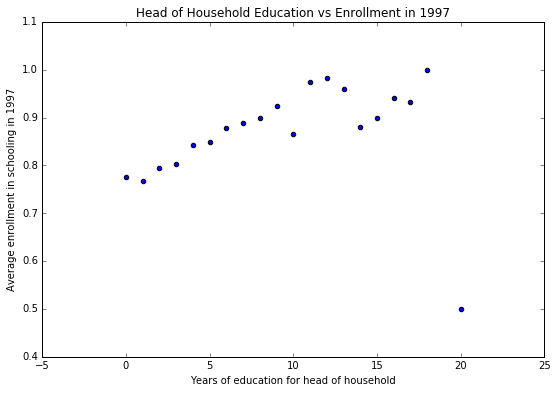

In [4]:
hoedu_mean_enrollment = progresa_df.groupby(['hohedu']).sc97.mean()
fig, ax = plt.subplots(figsize=(9,6))
ax.scatter(hoedu_mean_enrollment.index.tolist(), hoedu_mean_enrollment.values)
ax.set_title('Head of Household Education vs Enrollment in 1997')
ax.set_xlabel('Years of education for head of household')
ax.set_ylabel('Average enrollment in schooling in 1997')

The general trend points to a higher enrollment in schooling in 1997 for a higher number of years of education for the head of the household. The relationship is unsurprising, considering that it makes sense that parents with more education would probably encourage their children to do the same. 

Besides the general trend, it seems that at past around 10 years of education, there isn't an observable relationship between the variables. This may point to threshold for parental education vs enrollment in schooling for children.

Finally, at 20 years of education we see a baffling outlier. The average enrollment for that group in 1997 is only slightly above 0.5, lower than all of the other group by a wide margin. Maybe this specific subset of the group didn't enroll their children in public education - maybe homeschooling or private schooling is the reason for this difference.

### 1.5 Graphical exploration, part 2

Create a histogram of village enrollment rates **among poor households in treated villages**, before and after treatment. Specifically, for each village, calculate the average rate of enrollment of poor households in treated villages in 1997, then compute the average rate of enrollment of poor households in treated villages in 1998. Create two separate histograms showing the distribution of these average enrollments rates, one histogram for 1997 and one histogram for 1998. On each histogram, draw a vertical line that intersects the x-axis at the average value (across all households). Does there appear to be a difference? Is this difference statistically significant?

(0.5, 1)

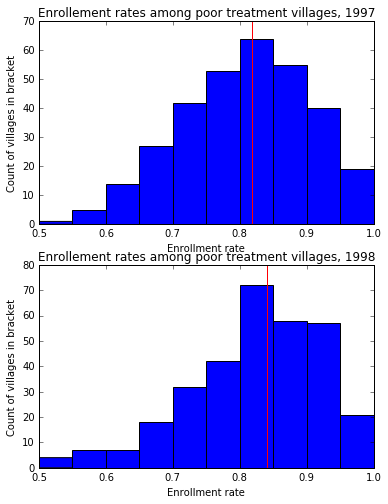

In [5]:
treatment_df = progresa_df.groupby(['progresa']).get_group('basal')
by_village97 = treatment_df.ix[97].groupby('village')
by_village98 = treatment_df.ix[98].groupby('village')

fig, axarr = plt.subplots(2)
fig.set_size_inches(6,8)

treat97 = by_village97.sc.mean()
axarr[0].hist(treat97[~np.isnan(treat97)], bins=np.arange(0.5, 1.1, 0.05))
axarr[0].axvline(treatment_df.ix[97].sc.mean(), color='red')
axarr[0].set_title('Enrollement rates among poor treatment villages, 1997')
axarr[0].set_xlabel('Enrollment rate')
axarr[0].set_ylabel('Count of villages in bracket')
axarr[0].set_xlim([0.5, 1])

treat98 = by_village98.sc.mean()
axarr[1].hist(treat98[~np.isnan(treat98)], bins=np.arange(0.5, 1.05, 0.05))
axarr[1].axvline(treatment_df.ix[98].sc.mean(), color='red')
axarr[1].set_title('Enrollement rates among poor treatment villages, 1998')
axarr[1].set_xlabel('Enrollment rate')
axarr[1].set_ylabel('Count of villages in bracket')
axarr[1].set_xlim([0.5, 1])

Overall, there seems to be a small but noticeable difference in average enrollment rates of poor, treated villages in 1997 vs 1998. In 1997, it seem that the average enrollment rate is at around 0.815 or so, and jumps to about 0.845 in 1998. It is hard to tell wether this difference is statistically significant just by viewing the two histograms. We can run a simple t-test to check the statistical significance of this finding.

In [6]:
ttest_ind(treatment_df.ix[97].sc, treatment_df.ix[98].sc, nan_policy='omit')

Ttest_indResult(statistic=-6.1976243535032669, pvalue=5.7847634518205522e-10)

We get a p-value of 5.78e-10 from the t-test above for village enrollment rates in 1997 and 1998. Thus we can say that even though the difference is rather small, it is statistically significant for sure.

## Part 2: Measuring Impact

Our goal is to estimate the causal impact of the PROGRESA program on the social and economic outcomes of individuals in Mexico. We will focus on the impact of the program on the poor (those with poor=='pobre'), since only the poor were eligible to receive the PROGRESA assistance.

### 2.1 Simple differences: T-test

Begin by estimating the impact of Progresa using "simple differences." Restricting yourself to data from 1998 (after treatment), calculate the average enrollment rate among **poor** households in the Treatment villages and the average enrollment rate among **poor** households in the control villages. Use a t-test to determine if this difference is statistically significant. What do you conclude?

In [7]:
poor_df = progresa_df[progresa_df.poor == 'pobre'].ix[98]

treat_enrollment = poor_df[poor_df.progresa == 'basal'].sc
control_enrollment = poor_df[poor_df.progresa == '0'].sc

treat_mean = treat_enrollment.mean()
control_mean = control_enrollment.mean()
print 'Treatment group enrollment mean:', treat_mean
print 'Control group enrollment mean:', control_mean
print 'Differnce (treat - control):', treat_mean - control_mean
ttest_ind(treat_enrollment,
          control_enrollment,
          nan_policy='omit')

Treatment group enrollment mean: 0.846479121395
Control group enrollment mean: 0.80763695673
Differnce (treat - control): 0.0388421646651


Ttest_indResult(statistic=8.3587205674183735, pvalue=6.6363444473781018e-17)

The differnce in school enrollment rates between treated and untreated villages in 1998, though rather small, is very statistically significant.

### 2.2 Simple differences: Regression

Estimate the effects of Progresa on enrollment using a regression model, by regressing the 1998 enrollment rates **of the poor** on treatment assignment. Discuss the following:

* Based on this model, how much did Progresa increase the likelihood of a child enrolling?
* How does your regression estimate compare to your t-test estimate from part 2.1?
* Based on this regression model, can we reject the null hypothesis that the treatment effects are zero? 
* What is the counterfactual assumption underlying this regression?

In [8]:
def treatment_to_num(row):
    if row.progresa == 'basal':
        row.progresa = 1
    elif row.progresa == '0':
        row.progresa = 0
    return row

enrollment_df = poor_df.apply(treatment_to_num, axis=1)
treat_to_enroll_mod = smf.ols(formula='sc ~ progresa', data=enrollment_df, missing='drop')
treat_to_enroll_res = treat_to_enroll_mod.fit()
print treat_to_enroll_res.summary()

                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     69.87
Date:                Fri, 22 Apr 2016   Prob (F-statistic):           6.64e-17
Time:                        11:28:22   Log-Likelihood:                -11926.
No. Observations:               27450   AIC:                         2.386e+04
Df Residuals:                   27448   BIC:                         2.387e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.8076      0.004    220.676      0.0

- Based on this model, Progresa increased the likelihood of a chiled enrolling by about 3.88%.
- The regression used here and the simple t-test from section 2.1 yield the exact same p-value and measure the same difference between the treated and untreated groups.
- Considering that the p-value is exteremely small, we can safely reject the null hypthesis that the are no treatment effects.
- The underlying conterfactual is that had the treatment not been administered to the treatment group, then the enrollment rates would have been the same as the untreated village's enrollment rates.

### 2.3 Multiple Regression

Re-run the above regression estimated but this time include a set of control variables. Include, for instance, age, distance to a secondary school, gender, education of household head, welfare index, indigenous, etc.

* How do the controls affect the point estimate of treatment effect?
* How do the controls affect the standard error on the treatment effect? 
* How do you interpret the differences (or similarities) between your estimates of 2.2 and 2.3?

In [9]:
controls_mod = smf.ols('sc ~ progresa + age + dist_sec + hohedu', data=enrollment_df, missing='drop')
controls_res = controls_mod.fit()
print controls_res.summary()

                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     2444.
Date:                Fri, 22 Apr 2016   Prob (F-statistic):               0.00
Time:                        11:28:22   Log-Likelihood:                -7778.5
No. Observations:               27450   AIC:                         1.557e+04
Df Residuals:                   27445   BIC:                         1.561e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.5510      0.009    169.427      0.0

- The controls slightly reduce the point estimate of the treatment effect. It went down from a coefficient of 0.0388 in the simple univariate regression to 0.0357 is this multivariate regression.
- It seems that the total std error on the treatment effect actually increased as a result of adding a few more control variables to the regression equation.
- The first regression in 2.2 presents a much more simple model of treatment effects, and thus is prone to a lower std error. However, since it only incorporates a single variable it has much less predictive power than the model in 2.3. Even though this multivariate regression has higher standard error, it will probably be more accurate in it's prediction of actual enrollment rateswith the given control variables taken into account.

### 2.4 Difference-in-Difference, version 1 (tabular)

Thus far, we have computed the effects of Progresa by estimating the difference in 1998 enrollment rates across villages. An alternative approach would be to compute the treatment effect using a difference-in-differences framework.

Begin by estimating the average treatment effects of the program for poor households using data from 1997 and 1998. Specifically, calculate the difference (between 1997 and 1998) in enrollment rates among poor households in treated villages; then compute the difference (between 1997 and 1998) in enrollment rates among poor households in control villages. The difference between these two differences is your estimate.

* What is your estimate of the impact, and how does it compare to your earlier (simple difference) results?
* What is the counterfactual assumption underlying this estimate? 


In [10]:
poor_df = progresa_df.copy()[progresa_df.poor == 'pobre']
poor97_groups = poor_df.ix[97].groupby(['progresa'])
poor98_groups = poor_df.ix[98].groupby(['progresa'])

control_sc97 = poor97_groups.get_group('0').sc.mean()
control_sc98 = poor98_groups.get_group('0').sc.mean()
treat_sc97 = poor97_groups.get_group('basal').sc.mean()
treat_sc98 = poor98_groups.get_group('basal').sc.mean()

print "Control enrollment 1997:", control_sc97
print "Control enrollment 1998:", control_sc98
print "Treatment enrollment 1997:", treat_sc97
print "Treatment enrollment 1998", treat_sc98

print "Double difference (T1 - T0) - (C1 - C0):", (treat_sc98 - treat_sc97) - (control_sc98 - control_sc97)

Control enrollment 1997: 0.815186003058
Control enrollment 1998: 0.80763695673
Treatment enrollment 1997: 0.822696887403
Treatment enrollment 1998 0.846479121395
Double difference (T1 - T0) - (C1 - C0): 0.0313312803193


- The estimate of the impact of the progresa program shows an increase in school enrollment by an average of %3.13 for treated villages. We predicted a bigger impact with simple difference results, at around a %3.88 increases in school enrollment. In this double difference case we actually accounted for the overall trend of school enrollment and the fact that the treatment villages had a slightly higher enrollment rate in 1997. This is why our predicted impact here is smaller.
- The conterfactual in this estimate states that had the treatment group not been administered the treatment in this experiment, then the trend of school enrollment would've been the same between '97-'98 as the control group.

### 2.5 Difference-in-Difference, version 2 (regression)

Now use a regression specification to estimate the average treatment effects of the program in a difference-in-differences framework. Include at least 5 control variables.

* What is your estimate of the impact of Progresa? Be very specific in interpreting your coefficients and standard errors, and make sure to specify exactly what units you are measuring and estimating.
* How do these estimates of the treatment effect compare to the estimates based on the simple difference?
* How do these estimates compare to the difference-in-difference estimates from 2.4 above? What accounts for these differences?
* What is the counterfactual assumption underlying this regression? 

In [11]:
def progresa_num(val):
    if val == 'basal':
        return 1
    elif val == '0':
        return 0
    else:
        return val

poor_df['period'] = poor_df.index.to_series().apply(lambda x: x - 97)
poor_df['progresa'] = poor_df.progresa.apply(progresa_num)
dd_mod = smf.ols(formula='sc ~ progresa + period + age + dist_sec + hohedu + sex + hohsex + progresa * period', 
                 data=poor_df)
dd_res = dd_mod.fit()
print dd_res.summary()

                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     2765.
Date:                Fri, 22 Apr 2016   Prob (F-statistic):               0.00
Time:                        11:28:23   Log-Likelihood:                -16888.
No. Observations:               58345   AIC:                         3.379e+04
Df Residuals:                   58336   BIC:                         3.387e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           1.5040      0.008    1

- Overall, the impact of progresa by itself reduces to %0.39 percent in this regression. This does not meach much. All it says is that being in the treatment group affects the odds of being enrolled at school even before the treatment is administered. However, the impact of progresa with time (pre/post treatment) comes to about %3.15. The std error of 0.006 for progresa:period represents the treatment * period factor here. It is 0.004 for the period predictor, and 0.004 for the progresa predictor, both of these are smaller than the errors measured for the treatment in the previous regression, but compound together since we have more terms in this equation. The units for these error terms are in % enrollment rate.
- Our simple-differences analysis yielded an estimated impact of %3.88 increase in enrollment for treated villages. This a noticeably larger predicted impact than in our regression here. The major difference in this double-difference regression is that we are accounting for overall trends and initial school enrollments for both the control and treatment groups. Considering that, we saw a more diminished impact since we started with hight enrollments for treatment groups at the beginning of the experiment.
- The value for the impact of treatment + time is actually very similar to our prediction in the double difference section. We estimated an impact of %3.13 increase in school enrollment for treated villages. That's extremely close to our regression prediction here. Our standard error for progresa has actually decreased significantly from %0.009 enrollment in 2.4 to %0.004. This is likely due to the fact that we have included the period of the study and 1997 survey results. When accounting for the period of the data, we reduced the error that assumed that being in the treatment group inherently increases schooling rates.
- The counterfactual here says that if our treatment group (progresa) remained untreated, we would've seen an overall trend in school enrollment rate matching to that of our control group.

### 2.6 Summary

* Based on all the analysis you have undertaken to date, do you believe that Progresa had a causal impact on the enrollment rates of poor households in Mexico? 
* Describe one other way that you might analyze these data to further investigate the causal impact of Progresa on enrollment, and clearly state the counterfactual assumption you would need to make for that approach to be valid.  *(Hint: Consider using the non-poor in your analysis)*

- Based on the analysis I've undertaken, I'm convinced that the progresa program had a measurable, causal impact on the enrollment rates of poor households in mexico. Though it was a small impact of under %4 increase in treated villages, the measured difference was statistically significant. The impact becomes even more significant when we consider that Mexico experienced a trend of decline in school enrollment in untreated poor villages overall. Regradless of what caused this effect, progresa had a clear impact on the villages that it treated.
- For further analysis of this data, I would try to compare the overall trends in untreated poor & not poor households to see what the overall schooling trends are for the general population of mexico. I would use this maybe for another regression prediction or a difference-in-difference analysis. It could be that we saw a decrease in school enrollment rates in our control poor villages due to random chance.